In [1]:
import jax
import jax.numpy as jnp
import time

# --- 1. JAX Setup ---
key = jax.random.PRNGKey(42)

# --- 2. Imports from the 'chewc' library ---
from chewc.sp import SimParam
from chewc.population import Population, msprime_pop # Use msprime_pop
from chewc.trait import add_trait_a
from chewc.burnin import run_burnin
# Import the generation runner
from chewc.pipe import run_generation


There are two functions to simulate founder genomes

1) quickHaplo

    this simulate a randomized population where each haplotype generated is 1/0. This creates founders with high amounts of genetic diversity and no population structure.

2) msprime_pop

    this function uses the msprime python library to create populations with population structures generated through a separate coalescent simulation

In [2]:
from dataclasses import field
from typing import List, Optional, Dict, Callable

from flax.struct import dataclass as flax_dataclass # Using flax's dataclass for JAX-friendliness
import jax
import jax.numpy as jnp

# from chewc.sp import SimParam

import msprime
import tskit
import numpy as np
import random
from collections import defaultdict

key, pop_key = jax.random.split(key)
nInd = 5
nChr = 2
segSites = 100

founder_genomes = msprime_pop(pop_key, nInd, segSites, nChr)
founder_genomes

Population(nInd=5, nTraits=0, has_ebv=No)

In [3]:
# The founder_genomes object already contains the genetic map and genotype info
SP = SimParam(founderPop=founder_genomes)

In [4]:
SP

SimParam(nChr=2, nTraits=0, ploidy=2, sexes='no')

In [5]:
# Access the founder pop in the Sim Params
SP.founderPop

Population(nInd=5, nTraits=0, has_ebv=No)

In [6]:
# Get the number of individuals in the founder pop
SP.founderPop.nInd

5

In [7]:
# Get the individual ID's 
SP.founderPop.id

Array([0, 1, 2, 3, 4], dtype=int32)

In [8]:
SP.founderPop.nChr

2

In [9]:
SP.founderPop.geno.shape

(5, 2, 2, 100)

In [10]:
SP.founderPop.geno

Array([[[[0, 0, 1, ..., 0, 1, 1],
         [0, 0, 0, ..., 1, 0, 0]],

        [[0, 0, 0, ..., 0, 1, 0],
         [1, 1, 0, ..., 0, 1, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 1, 0]]],


       [[[1, 1, 1, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 1, 0]],

        [[1, 1, 0, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 1, 0]]],


       [[[0, 0, 0, ..., 0, 1, 1],
         [0, 0, 1, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 1, 0]]],


       [[[1, 1, 1, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 1, 0],
         [0, 1, 1, ..., 0, 1, 0]]]], dtype=uint8)

In [11]:
SP.founderPop.haplo_matrix

Array([[0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [12]:
flattened_array = SP.founderPop.geno.transpose(0, 2, 1, 3).reshape(SP.founderPop.geno.shape[0] * SP.founderPop.geno.shape[2], -1)

In [13]:
flattened_array.shape

(10, 200)

In [14]:
# Transpose the array so that loci are in rows
transposed_array = flattened_array.T
print(f"Transposed shape: {transposed_array.shape}")     # (loci, samples)

# Calculate the correlation matrix
locus_correlations = np.corrcoef(transposed_array)

print(f"Shape of correlation matrix: {locus_correlations.shape}") # (loci, loci)
print("\nCorrelation matrix (top 5x5 corner):")
print(locus_correlations[:5, :5])


Transposed shape: (200, 10)
Shape of correlation matrix: (200, 200)

Correlation matrix (top 5x5 corner):
[[ 1.          1.          0.5         0.25       -0.61237244]
 [ 1.          1.          0.5         0.25       -0.61237244]
 [ 0.5         0.5         1.          0.         -0.40824829]
 [ 0.25        0.25        0.          1.          0.61237244]
 [-0.61237244 -0.61237244 -0.40824829  0.61237244  1.        ]]


/home/glect/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/glect/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [15]:
plt.hist(locus_correlations.flatten())

NameError: name 'plt' is not defined

In [ ]:
SP.founderPop.dosage.shape

(5, 200)

Column Means:
[0.1        0.6        0.1        0.2        0.2        0.4
 0.5        0.3        0.1        0.2        0.7        0.7
 0.         0.7        0.         0.3        0.6        0.1
 0.3        0.2        0.3        0.7        0.1        0.4
 0.2        0.2        0.1        0.1        0.4        0.3
 0.4        0.1        0.7        0.7        0.1        0.6
 0.1        0.6        0.2        0.2        0.2        0.5
 0.8        1.         0.2        0.5        0.         0.6
 0.4        0.6        0.3        0.7        0.5        0.90000004
 0.2        0.6        0.1        0.2        0.8        0.4
 0.2        0.2        0.1        0.2        0.1        0.6
 0.         0.6        0.         0.         0.         0.2
 1.         0.3        0.2        0.2        0.3        0.2
 0.1        0.         0.         0.1        0.4        0.4
 0.1        0.1        0.1        0.3        0.90000004 1.
 0.8        0.         0.4        0.1        0.2        0.7
 0.3        0.1     

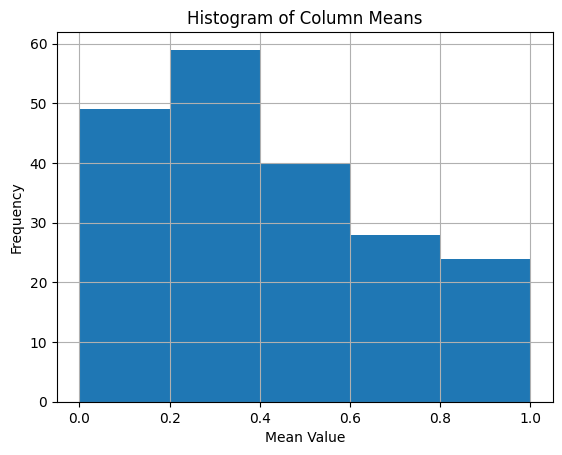

In [ ]:
import matplotlib.pyplot as plt
# Calculate the column means
column_means = np.mean(SP.founderPop.dosage, axis=0)
column_means = column_means * .5
print("Column Means:")
print(column_means)

# Create a histogram of the column means
plt.hist(column_means, bins=5)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Histogram of Column Means')
plt.grid(True)